# Predicting the Most Popular Song of 2024 (so far)

This extra credit utilizes the [*Spotify Top Hit 2010-2023 Kaggle Dataset*](https://www.kaggle.com/datasets/josephinelsy/spotify-top-hit-playlist-2010-2022) which uses the Spotify API to extract data directly. 

## Introduction

Music is something that is unavoidable in our lives. Whether we have paid subscriptions to Spotify or YouTube music, or scrolling through TikTok, or even listening to the radio, it's everywhere. This notebook intends to find out what makes a song popular via its audio features as opposed to outstanding factors such as world events and usage on social media. With that being said, here are a few leading questions that result in the following analysis: <br>
* Which audio features are most relevant in predicting the most popular track?
* Does the key that a track is in have any impact on how popular a track is? And if so, what key tends to be the most used amongst artists?
* What are the current trends of audio features in today's music?

Here are the variables that are used in the data set with a brief description, taken from the [Spotify API Website](https://developer.spotify.com/documentation/web-api). <br>
* **playlist_url:** URL of the playlist that the song is on
* **year:** year a song was released
* **track_id:** Spotify ID for the track
* **track_name:** name of the song
* **track_popularity:** how popular a track is ranging from 0 to 100, with 100 being the most popular
* **acousticness:** a confidence measure of whether the track is acoustic (i.e. no electronic enhancements) from 0.0 to 1.0 with 1.0 being high confidence that a track is acoustic
* **danceability:** how suitable a song is for dancing based on tempo, rhythm, beat, and regularity; ranges from 0.0 to 1.0 with 1.0 being most danceable
* **duration_ms:** Duration of the track in milliseconds
* **energy:** measures how energetic a song is from 0.0 to 1.0 (i.e. track is fast, loud, and noisy)
* **instrumentalness:** measures how much a song contains vocals, ranging from 0.0 to 1.0 with tracks above 0.5 intended to represent instrumental tracks. Note, "ooh" and "aah" sounds are counted as instrumental 
* **key:** The key the track is in, based on Pitch class notation, ranging from 0 to 9. No key is represented as -1.
* **liveness:** determines the presence of an audience in recording ranging from 0.0 to 1.0, with a value above 0.8 suggesting the track is live
* **loudness:** measures the loudness of a track in decibels(dB) ranging from -60 to 0 dB
* **mode:** Indicates if a track is major (1) or minor (0)
* **speechiness:** Detects the presence of spoken words in a track ranging from 0.0 to 1.0 with 1.0 being a speech-like recording (i.e. talk show, audio book, poetry)
* **tempo:** a float value indicating measured in beats per minute (BPM)
* **time_signature:** meter notation to specify how many beats are in a measure, ranging from 3 to 7 (represented as 3/4 or 4/4)
* **valence:** measures how positive a track sounds (i.e. happy, cheerful) from 0.0 to 1.0 with 1.0 indicating a track with high valence.

### Setup

The following lines of code import libraries needed for this project and read in a csv file into a Pandas Dataframe called **'playlist'**. A few options are set, as the encoding of the csv needs to be 'latin-1' to get rid of any errors while reading the csv. Another setting to display all 23 columns in the dataframe is also enabled here.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

ModuleNotFoundError: No module named 'sklearn'

In [4]:
# read in the data set
# encoding needed to be latin-1 to get rid of any errors
playlist = pd.read_csv('playlist_2010to2023.csv', encoding='latin-1')

In [5]:
# set to display all columns
pd.set_option('display.max_columns', None)

Later, for building a model, we will need a test data set, called **playlist_2024** which contains the top 50 hits of today. This was collected on April 24, 2024 using the Spotify API. The code to get this data set was inspired by this [notebook on Kaggle](https://www.kaggle.com/code/josephinelsy/spotify-top-hit-2010-2022/) and can be viewed in the notebook titled "spotify-top-hit-2024".

In [6]:
playlist_2024 = pd.read_csv('playlist_2024.csv', encoding='latin-1')

### Data Cleaning

Before proceeding with cleaning, let's display the first 5 values of the dataframe with all 23 columns.

In [7]:
playlist.head()

,playlist_url,year,track_id,track_name,track_popularity,album,artist_id,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,81,Oops!... I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,"['dance pop', 'pop']",81,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,211160,4
1,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,2m1hi0nfMR9vdGC8UcrnwU,All The Small Things,83,Enema Of The State,6FBDaR13swtiWwGhX1WQsP,blink-182,"['alternative metal', 'modern rock', 'pop punk...",79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,167067,4
2,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,3y4LxiYMgDl4RethdzpmNe,Breathe,66,Breathe,25NQNriVT2YbSW80ILRWJa,Faith Hill,"['contemporary country', 'country', 'country d...",62,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,250547,4
3,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,0v1XpBHnsbkCn7iJ9Ucr1l,It's My Life,81,Crush,58lV9VcRSjABbAbfWS6skp,Bon Jovi,"['glam metal', 'rock']",79,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,224493,4
4,https://open.spotify.com/playlist/37i9dQZF1DWU...,2000,62bOmKYxYg7dhrC6gH9vFn,Bye Bye Bye,75,No Strings Attached,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,"['boy band', 'dance pop', 'pop']",70,0.610,0.926,8,-4.843,0,0.0479,0.0310,0.001200,0.0821,0.861,172.638,200400,4


In [8]:
playlist_2024.head()

,playlist_url,year,track_id,track_name,track_popularity,album,artist_id,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,https://open.spotify.com/playlist/37i9dQZF1DXc...,2024,2OzhQlSqBEmt7hmkYxfT6m,Fortnight (feat. Post Malone),89,THE TORTURED POETS DEPARTMENT,06HL4z0CvFAxyc27GXpf02,Taylor Swift,['pop'],100,0.675,0.397,11,-10.895,1,0.0245,0.499000,0.000006,0.0939,0.319,95.988,228965,4
1,https://open.spotify.com/playlist/37i9dQZF1DXc...,2024,4IadxL6BUymXlh8RCJJu7T,Too Sweet,90,Unheard,2FXC3k01G6Gw61bmprjgqS,Hozier,"['irish singer-songwriter', 'modern rock', 'po...",85,0.741,0.620,10,-5.505,1,0.0412,0.029500,0.000809,0.0398,0.934,117.038,251424,4
2,https://open.spotify.com/playlist/37i9dQZF1DXc...,2024,2GxrNKugF82CnoRFbQfzPf,i like the way you kiss me,100,i like the way you kiss me,0PCCGZ0wGLizHt2KZ7hhA2,Artemas,[],81,0.599,0.946,11,-4.263,1,0.0447,0.000938,0.010600,0.0826,0.747,151.647,142515,4
3,https://open.spotify.com/playlist/37i9dQZF1DXc...,2024,2qSkIjg1o9h3YT9RAgYN75,Espresso,92,Espresso,74KM79TiuVKeVCqs8QtB0B,Sabrina Carpenter,['pop'],81,0.701,0.771,0,-5.486,1,0.0293,0.133000,0.000012,0.1970,0.661,103.982,175459,4
4,https://open.spotify.com/playlist/37i9dQZF1DXc...,2024,3rUGC1vUpkDG9CZFHMur1t,greedy,97,greedy,45dkTj5sMRSjrmBSBeiHym,Tate McRae,['pop'],83,0.750,0.733,6,-3.180,0,0.0319,0.256000,0.000000,0.1140,0.844,111.018,131872,1


We can drop unique columns such as playlist_url and artist_id, since they are not necessary for analysis.

In [9]:
playlist = playlist.drop(columns=['playlist_url', 'artist_id', 'track_id'], axis=1)
playlist_2024 = playlist_2024.drop(columns=['playlist_url', 'artist_id', 'track_id'], axis=1)

In [10]:
# Uncomment to display for assurance
#playlist.head()
#playlist_2024.head()

Finally, let's determine if there are any null values in the dataframe to remove or fill.

In [11]:
playlist.isnull().sum()

year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [12]:
playlist_2024.isnull().sum()

year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

There are no missing values in both the dataframes, therefore we can move on to exploring the data set further.

### Exploratory Data Analysis
This [link](https://towardsdatascience.com/is-my-spotify-music-boring-an-analysis-involving-music-data-and-machine-learning-47550ae931de) gave some inspiration for some of the analysis in this section, while this [article](https://medium.com/@FinchMF/praise-questions-and-critique-spotify-api-38e984a4174b) about the Spotify API gave some insight about the key variable in the Spotify API.

First, let's get to know our dataset. The following code displays the variable type for each column.

In [13]:
playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               2400 non-null   int64  
 1   track_name         2400 non-null   object 
 2   track_popularity   2400 non-null   int64  
 3   album              2400 non-null   object 
 4   artist_name        2400 non-null   object 
 5   artist_genres      2400 non-null   object 
 6   artist_popularity  2400 non-null   int64  
 7   danceability       2400 non-null   float64
 8   energy             2400 non-null   float64
 9   key                2400 non-null   int64  
 10  loudness           2400 non-null   float64
 11  mode               2400 non-null   int64  
 12  speechiness        2400 non-null   float64
 13  acousticness       2400 non-null   float64
 14  instrumentalness   2400 non-null   float64
 15  liveness           2400 non-null   float64
 16  valence            2400 

Next, we want to verify that the number of songs for each year. This is to make sure that during our analysis, that one year is more popular because it has more entries. The code below shows that, thankfully, there are 100 songs for each year.

<AxesSubplot:title={'center':'Number of Songs for Each Year'}, xlabel='Year', ylabel='Number of Songs'>

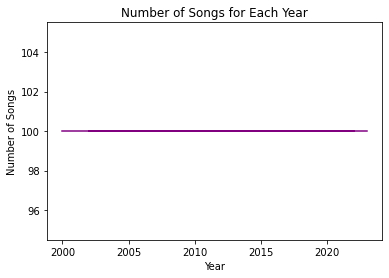

In [14]:
# Everything is even!
plt.xlabel('Year')
plt.ylabel('Number of Songs')
playlist["year"].value_counts().plot(color="purple", title='Number of Songs for Each Year')

**Data Frame Description** The following line of code shows information about numerical variables in the playlist dataframe. Here are some notes on some of the averages on the variables:
* The average <u>duration</u> of a song is 224695.583750 ms or 3 minutes and 47 seconds
* The average <u>time signature</u> is 3.975, but if rounded, the average time signature that most songs use is 4/4
* Average <u>tempo</u> is 120 beats per minute
* The average <u>loudness</u> is -5.8 decibels
* <u>Instrumentalness</u> is an average of 0.01 which indicates that the average track has more lyrics
* The average <u>speechiness</u> is 0.09 meaning that most tracks don't have the presence of spoken words

In [15]:
playlist.describe()

,year,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,2011.500000,70.277083,75.882500,0.661767,0.688705,5.238333,-5.811735,0.589167,0.097995,0.164838,0.013442,0.174978,0.536023,120.456363,224695.583750,3.975000
std,6.923629,12.958245,12.016746,0.140335,0.165345,3.596909,2.086712,0.492088,0.093276,0.210630,0.082364,0.134153,0.228995,27.640203,41652.938998,0.240276
min,2000.000000,0.000000,36.000000,0.162000,0.051900,0.000000,-21.107000,0.000000,0.022500,0.000013,0.000000,0.021000,0.037700,60.019000,97393.000000,1.000000
25%,2005.750000,65.000000,68.000000,0.573750,0.585000,2.000000,-6.846000,0.000000,0.037900,0.018075,0.000000,0.090475,0.359750,98.061500,199050.500000,4.000000
50%,2011.500000,72.000000,77.000000,0.673000,0.706000,5.000000,-5.526500,1.000000,0.056800,0.073600,0.000000,0.120500,0.544000,120.000000,220953.500000,4.000000
75%,2017.250000,78.000000,85.000000,0.760000,0.814000,8.000000,-4.381750,1.000000,0.115000,0.233000,0.000057,0.225000,0.726000,137.644500,245467.000000,4.000000
max,2023.000000,96.000000,100.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.978000,0.985000,0.979000,0.974000,210.857000,613027.000000,5.000000


** The "Key" Variable ** For reference, the Spotify API uses [Pitch Class Notation](https://en.wikipedia.org/wiki/Pitch_class). The next few lines of code find out the most used key in songs overall. Here, the most popular key used from 2000-2023 is 1, which are the tonal counterparts of C-sharp and D-flat. This is done by: <br>
1. Tabulating the number of times a key was used in a song for each year
2. Find the key that was used the most amount of times for each year
3. Create a dataframe with the columns year and the most used key for each year
4. Plot how many times each key was appeared in the dataframe

<AxesSubplot:title={'center':'Most Used Key in Songs (2000-2023)'}, xlabel='Key', ylabel='Counts'>

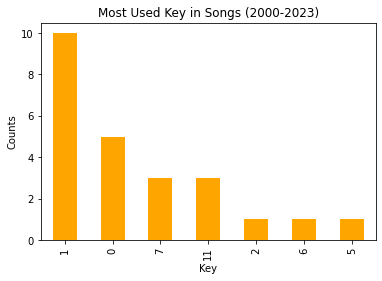

In [16]:
most_key = playlist.groupby('year').key.value_counts()
keys = []
for i in np.sort(playlist['year'].unique()):
    keys.append(most_key[i][most_key[i] == most_key[i].max()].index[0])


overall_key = pd.DataFrame()
overall_key['year'] = np.sort(playlist['year'].unique())
overall_key['key'] = keys
plt.xlabel('Key')
plt.ylabel('Counts')
overall_key['key'].value_counts().plot(kind='bar', title='Most Used Key in Songs (2000-2023)', color='orange')

Next, let's determine the most popular key based on track popularity. To do this, we group by the key variable and calculate the average track popularity associated with said key.

In [17]:
#popular_key = playlist.groupby(['year', 'key'])['track_popularity'].mean()
popular_key = playlist.set_index('key').groupby('key').track_popularity.mean().reset_index()
popular_key.sort_values(by='track_popularity',ascending=False)

,key,track_popularity
2,2,71.320197
1,1,71.099010
5,5,71.026316
11,11,70.504464
0,0,70.362595
8,8,70.229592
7,7,70.210762
4,4,69.927711
3,3,69.910256
9,9,69.510989


Based on the above data frame, key 2, which is the tonal counterpart of D is the key that appears the most with highly popular tracks. The next section of code pulls the top songs that have the key as 2. 

In [18]:
popular_keysong = playlist[playlist['key'] == 2]
popular_keysong = popular_keysong.sort_values(by="track_popularity", ascending=False).head(10)

# uncomment the following line to display data frame
popular_keysong.sort_values(by="track_popularity", ascending=False).head(10)

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2326,2023,Lovin On Me,93,Lovin On Me,Jack Harlow,"['deep underground hip hop', 'kentucky hip hop...",83,0.943,0.558,2,-4.911,1,0.0568,0.0026,0.000002,0.0937,0.606,104.983,138411,4
2361,2023,Standing Next to You,92,GOLDEN,Jung Kook,['k-pop'],86,0.711,0.809,2,-4.389,0,0.0955,0.0447,0.000000,0.3390,0.816,106.017,206020,4
2304,2023,Daylight,91,Daylight,David Kushner,"['gen z singer-songwriter', 'singer-songwriter...",77,0.508,0.430,2,-9.475,0,0.0335,0.8300,0.000441,0.0930,0.324,130.090,212954,4
2218,2022,Ghost,87,Justice,Justin Bieber,"['canadian pop', 'pop']",89,0.601,0.741,2,-5.569,1,0.0478,0.1850,0.000029,0.4150,0.441,153.960,153190,4
1307,2013,Why'd You Only Call Me When You're High?,87,AM,Arctic Monkeys,"['garage rock', 'modern rock', 'permanent wave...",86,0.691,0.631,2,-6.478,1,0.0368,0.0483,0.000011,0.1040,0.800,92.004,161124,4
1306,2013,Wake Me Up,86,True,Avicii,"['dance pop', 'edm', 'pop', 'pop dance']",81,0.532,0.783,2,-5.697,1,0.0523,0.0038,0.001200,0.1610,0.643,124.080,247427,4
400,2004,Yeah! (feat. Lil Jon & Ludacris),86,Confessions (Expanded Edition),USHER,"['atl hip hop', 'contemporary r&b', 'dance pop...",83,0.894,0.791,2,-4.699,1,0.1120,0.0183,0.000000,0.0388,0.583,105.018,250373,4
2341,2023,La Bebe - Remix,86,La Bebe (Remix),Yng Lvcas,"['reggaeton', 'urbano mexicano']",70,0.812,0.479,2,-5.678,0,0.3330,0.2130,0.000001,0.0756,0.559,169.922,234353,4
1004,2010,TiK ToK,85,Animal (Expanded Edition),Kesha,"['dance pop', 'pop']",79,0.755,0.837,2,-2.718,0,0.1420,0.0991,0.000000,0.2890,0.714,120.028,199693,4
1904,2019,Sunflower - Spider-Man: Into the Spider-Verse,85,Hollywood's Bleeding,Post Malone,"['dfw rap', 'melodic rap', 'pop', 'rap']",88,0.755,0.522,2,-4.368,1,0.0575,0.5330,0.000000,0.0685,0.925,89.960,157560,4


The code below gets the 11 most popular tracks regardless of year. The reason why it's 11 instead of 10 is because the top two most popular tracks are both by Taylor Swift. The track "Cruel Summer" from her Lover album was re-released as a single in 2023 because of its rising popularity as one of the opening songs of the Eras Tour. As a result, it will be dropped in the next part of data analysis.

In [19]:
# What are the most popular tracks (of all time?)
sorted_popular = playlist.sort_values(by="track_popularity", ascending=False)
top_popular = sorted_popular.head(11)
# top_popular
# drop second entry of Cruel Summer
top_popular = top_popular.iloc[1:]
top_popular

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2307,2023,Cruel Summer,96,Lover,Taylor Swift,['pop'],100,0.552,0.702,9,-5.707,1,0.1570,0.11700,0.000021,0.1050,0.564,169.994,178427,4
2310,2023,greedy,96,greedy,Tate McRae,['pop'],85,0.750,0.733,6,-3.180,0,0.0319,0.25600,0.000000,0.1140,0.844,111.018,131872,1
2351,2023,My Love Mine All Mine,94,The Land Is Inhospitable and So Are We,Mitski,"['brooklyn indie', 'pov: indie']",84,0.504,0.308,9,-14.958,1,0.0321,0.86800,0.135000,0.1580,0.121,113.950,137773,4
2349,2023,I Wanna Be Yours,93,AM,Arctic Monkeys,"['garage rock', 'modern rock', 'permanent wave...",86,0.464,0.417,0,-9.345,0,0.0256,0.13600,0.022000,0.0974,0.479,67.528,183956,4
2326,2023,Lovin On Me,93,Lovin On Me,Jack Harlow,"['deep underground hip hop', 'kentucky hip hop...",83,0.943,0.558,2,-4.911,1,0.0568,0.00260,0.000002,0.0937,0.606,104.983,138411,4
605,2006,Unwritten,92,Unwritten,Natasha Bedingfield,"['dance pop', 'pop', 'post-teen pop']",76,0.706,0.800,5,-6.333,1,0.0399,0.00584,0.000000,0.0822,0.629,100.011,259333,4
2328,2023,Water,92,Water,Tyla,[],80,0.673,0.722,3,-3.495,0,0.0755,0.08560,0.000000,0.1370,0.519,117.187,200256,4
2334,2023,I Remember Everything (feat. Kacey Musgraves),92,Zach Bryan,Zach Bryan,['classic oklahoma country'],88,0.429,0.453,0,-7.746,1,0.0459,0.55400,0.000002,0.1020,0.155,77.639,227196,4
2343,2023,Houdini,92,Houdini,Dua Lipa,"['dance pop', 'pop', 'uk pop']",89,0.744,0.789,9,-4.876,0,0.0590,0.00360,0.001440,0.0947,0.866,116.985,185918,4
2361,2023,Standing Next to You,92,GOLDEN,Jung Kook,['k-pop'],86,0.711,0.809,2,-4.389,0,0.0955,0.04470,0.000000,0.3390,0.816,106.017,206020,4


From the above dataframe, we can tabulate which key appears the most on the list. Here, the most popular key is 5, or tonal counterpart of F. 

<AxesSubplot:title={'center':'Most Popular Key by Track Popularity (2000-2023)'}, xlabel='Key', ylabel='Counts'>

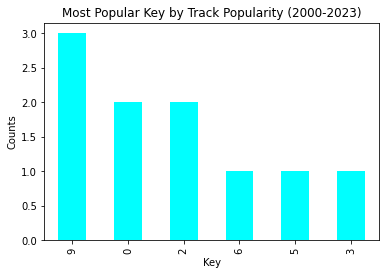

In [20]:
plt.xlabel('Key')
plt.ylabel('Counts')
top_popular['key'].value_counts().plot(kind='bar', title='Most Popular Key by Track Popularity (2000-2023)',
                                      color='cyan')

To summarize, the most popular key by average track popularity is 2, the key that appears the most in the top 10 most popular tracks of all time is 9, and the most used key amongst all tracks is 5. 

Before moving on from the key variable, since the list of most popular songs contains songs from 2023, it is worth it to find what key was used the most in 2023. From the bar plot below, 5 is the most used key in 2023.

<AxesSubplot:title={'center':'Most Used Key in 2023'}, xlabel='year,key', ylabel='Key Counts'>

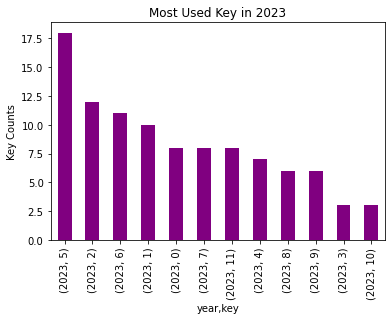

In [21]:
key_year = playlist[playlist["year"] == 2023]
plt.ylabel('Key Counts')
key_year.groupby("year").key.value_counts().plot(kind="bar", color="Purple",title="Most Used Key in 2023")                                                

**Popular Key vs. Popular Song** All these songs were released in the year of 2023, with the exception of Taylor Swift's Cruel Summer and Natasha Bedingfield's Unwritten, which was released in 2006. So far we have the top 10 popular songs and the top 10 popular songs by key. We can take the averages of both and plot them and examine their differences.

We can get the averages of each feature and plot them, which is what the following method performs. DF is a dataframe using the describe method to get the averages of all numeric variables in the playlist dataframe.

In [22]:
def get_averages(df, features):
    avg_list = []
    for i in features:
        avg_list.append(df[i]['mean'])
    return avg_list

In [23]:
top_popularDesc = top_popular.head(10).describe()
top_popular_keyDesc = popular_keysong.head(10).describe()
audio_features = ['acousticness', 'valence', 'energy', 'instrumentalness', 'danceability', 'liveness', 'speechiness']
popularDesc_list = get_averages(top_popularDesc, audio_features)
popular_keyDesc_list = get_averages(top_popular_keyDesc, audio_features)

Now we can create a bar chart of the averages of both.

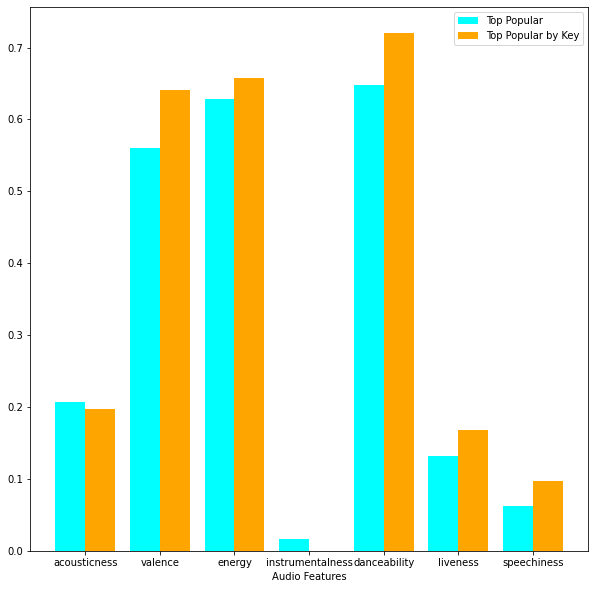

In [24]:
fig, axs = plt.subplots(figsize=(10,10))
x = np.arange(7)
plt.bar(x-0.2, popularDesc_list, width = 0.4, color='cyan')
plt.bar(x+0.2, popular_keyDesc_list, width = 0.4, color='orange')
plt.xticks(x, audio_features)
plt.legend(["Top Popular", "Top Popular by Key"])
plt.xlabel("Audio Features")
plt.show()

Songs with the key of 2 have higher valence, energy, danceability, liveness, and speechiness. In other words, these songs are more upbeat and only slightly more spoken word, but overall still musical in comparison to the most popular song. The 10 most popular songs have more acousticness and instrumentalness.

The next bar plot shows the differences between the averages of the most popular songs and the most popular songs with a key of 2. 

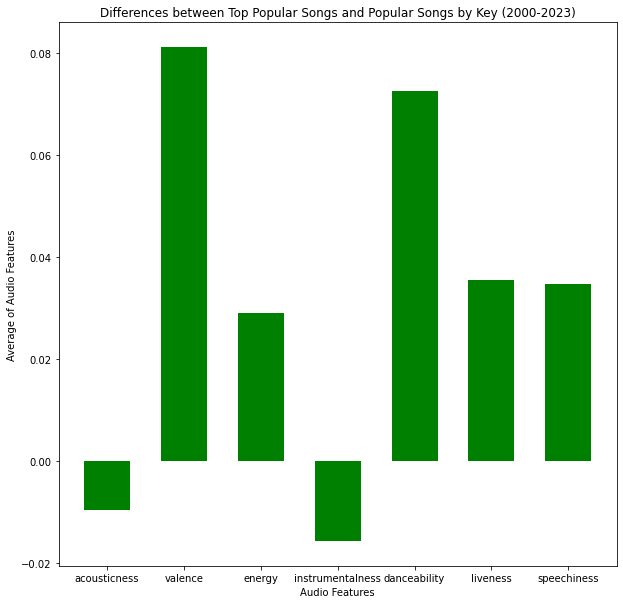

In [25]:
differences = [a_y - a_x for a_x, a_y in zip(popularDesc_list, popular_keyDesc_list)]
fig, axs = plt.subplots(figsize=(10,10))
plt.bar(audio_features, differences, width = 0.6, color = "Green")
plt.xlabel("Audio Features")
plt.ylabel("Average of Audio Features")
plt.title("Differences between Top Popular Songs and Popular Songs by Key (2000-2023)")
plt.show()

**Audio Feature Trends** The next section of code plots a variety of audio features against track popularity. First, we should plot the average track popularity by year to see which year had the most popular tracks. From the below chart, track popularity has been rising since 2000 before drastically dipping in 2020 before quickly rising after. 

In [26]:
avg_trackPop = playlist.groupby("year")[["track_popularity"]].mean()

<AxesSubplot:title={'center':'Average Track Popularity (by Year)'}, xlabel='year'>

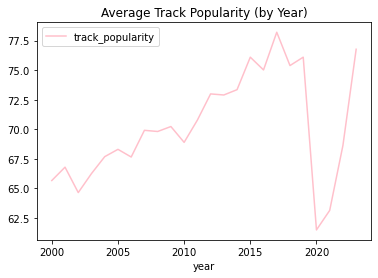

In [27]:
avg_trackPop.plot(color="pink",title="Average Track Popularity (by Year)")

In [28]:
# uncomment to display values
# avg_trackPop

The next two lines find the lowest and highest track popularity. 2017 had the highest track popularity while 2020 had the lowest.

In [29]:
max(avg_trackPop['track_popularity']) #2017 had the most popular track popularity

78.21

In [30]:
min(avg_trackPop['track_popularity']) # lowest track popularity was in 2020

61.48

**Energy vs. Year** Since 2010, the energy in music has decreased, meaning that the pacing in music has been slower and is less loud.

<AxesSubplot:title={'center':'Average Energy vs. Year for Tracks'}, xlabel='year'>

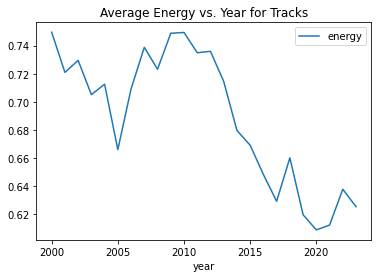

In [31]:
avg_energy = playlist.groupby("year")[["energy"]].mean()
avg_energy.plot(title='Average Energy vs. Year for Tracks')

**Danceability vs. Year** The danceability in songs has increased since 2010-2011 before taking a big dip after 2020. Since then, songs have been increasing in danceability but to see whether it will reach its peak as prior to 2020 is yet to be seen.

<AxesSubplot:title={'center':'Average Danceability vs. Year for Tracks'}, xlabel='year'>

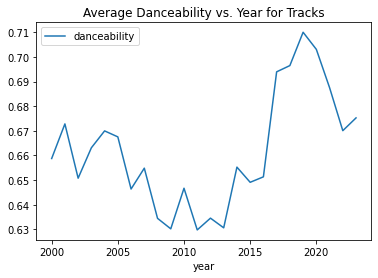

In [32]:
avg_danceability = playlist.groupby("year")[["danceability"]].mean()
avg_danceability.plot(title='Average Danceability vs. Year for Tracks')

** Tempo vs. Year** Song's tempo peaked prior to 2010, but so far most modern songs since 2020 have remained above 120 bpm.

<AxesSubplot:title={'center':'Average Tempo vs. Year for Tracks'}, xlabel='year'>

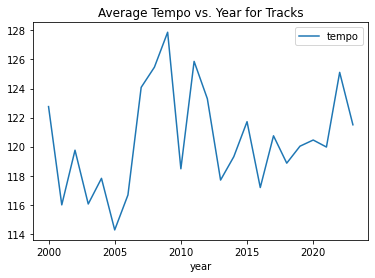

In [36]:
playlist.groupby("year")[["tempo"]].mean().plot(title='Average Tempo vs. Year for Tracks')

**Duration (in ms) vs. Year** Duration in songs has been decreasing for the past 20 years.

<AxesSubplot:title={'center':'Average Duration vs. Year for Tracks'}, xlabel='year'>

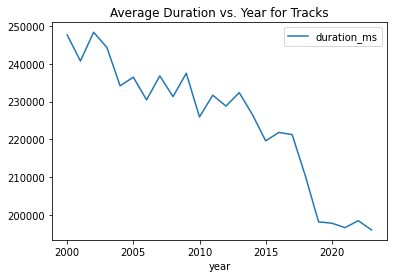

In [34]:
playlist.groupby("year")[["duration_ms"]].mean().plot(title='Average Duration vs. Year for Tracks')

**Speechiness vs. Year** While still below what is deemed to be spoken word, speechiness in songs has been decreasing since 2019-2020.

<AxesSubplot:title={'center':'Average Speechiness vs. Year for Tracks'}, xlabel='year'>

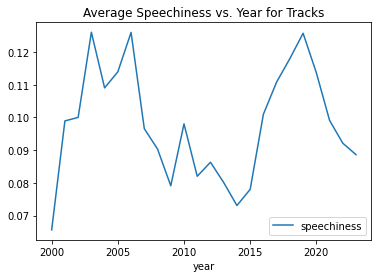

In [35]:
# plot speechiness 
playlist.groupby("year")[["speechiness"]].mean().plot(title='Average Speechiness vs. Year for Tracks')

**Instrumentalness vs Year** Instrumentalness has been increasing recently after 2021, but it is still less than what it was in the early 2000s and 2010s. This means that there are more lyrics in songs as opposed to instrumentals.

<AxesSubplot:title={'center':'Average Instrumentalness vs. Year for Tracks'}, xlabel='year'>

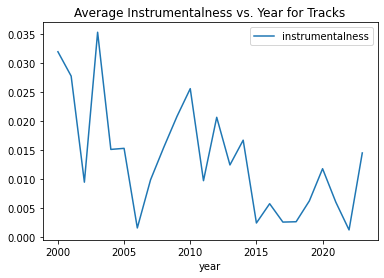

In [71]:
playlist.groupby("year")[["instrumentalness"]].mean().plot(title='Average Instrumentalness vs. Year for Tracks')

**Valence vs Year** Songs have been significantly less happy-sounding since 2000. However after 2015, valence has been increasing suggesting that songs have been sounding happier lately.

<AxesSubplot:title={'center':'Average Valence vs. Year for Tracks'}, xlabel='year'>

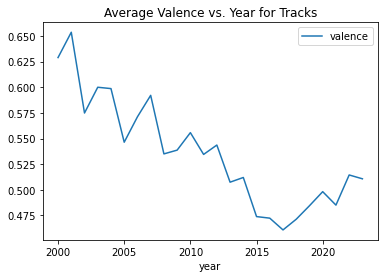

In [70]:
playlist.groupby("year")[["valence"]].mean().plot(title='Average Valence vs. Year for Tracks')

**Addressing Collinearity** The following code generates a correlation heatmap. Here, let's define two varaibles that have high correlation as greater than +/- 0.5

In [30]:
correlation_cols = ['track_popularity', 'danceability', 'energy', 'key', 
                   'loudness', 'mode', 'speechiness', 'acousticness', 
                   'instrumentalness', 'valence', 'tempo', 
                   'duration_ms', 'time_signature', 'artist_popularity']

In [31]:
mask = np.triu(np.ones_like(playlist[correlation_cols].corr(), dtype=bool))

<AxesSubplot:>

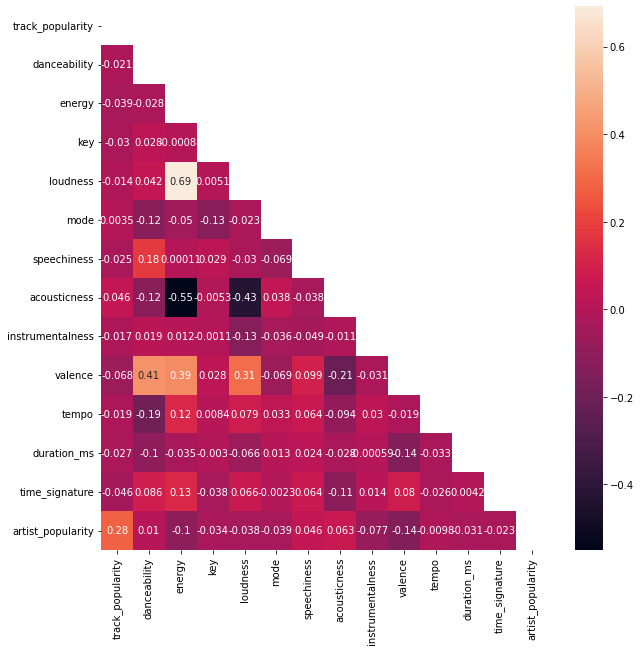

In [32]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(playlist[correlation_cols].corr(), ax=ax, annot=True, mask=mask)

Energy and Loudness are positively correlated. Louder music means that a song has more energy. Converesely, Acousticness and Energy are negatively correlated, meaning there is less electrical amplification with lower Energy songs. From this matrix, removing Acousticness and Loudness from the model would increase performance. 

**Addressing Multicollinearity** A correlation matrix is one way to deal with Collinearity. However, variables can be correlated with multiple other variables. To measure this, the <u>Variance Inflation Factor (VIF)</u> can be used to measure how correlated other variables are with each other. A VIF of higher than 5 means high collinearity with other independent variables, which will cause issues when performing linear regression. The VIF formula is as follows: 
<center>
$VIF \equiv \frac{1}{1-R^2}$

This site was used for an algorithm for [multicollinearity](https://towardsdatascience.com/targeting-multicollinearity-with-python-3bd3b4088d0b).

In [73]:
# get numeric data from playlist for collinearity
playlist_nums = playlist._get_numeric_data()

In [27]:
playlist_nums.head()

,year,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2000,81,81,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,211160,4
1,2000,83,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,167067,4
2,2000,66,62,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,250547,4
3,2000,81,79,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,224493,4
4,2000,75,70,0.610,0.926,8,-4.843,0,0.0479,0.0310,0.001200,0.0821,0.861,172.638,200400,4


In [28]:
def compute_vif(considered):
    vif = pd.DataFrame() 
    X = playlist_nums[considered]
    #X['intercept'] = 1
    #vif["intercept"] = 1
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
    vif = vif[vif["features"] != 'intercept']
    return vif

The above function will be called to calculate correlation amongst the independent variables. Considered_cols will remove track_popularity since it is not an independent variable. 

In [29]:
considered_cols = playlist_nums.columns
considered_cols = list(considered_cols)
considered_cols.remove('track_popularity')
considered_cols

['year',
 'artist_popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature']

In [74]:
# Uncomment to view
# playlist_nums[considered_cols].head()

The algorithm to determine the variables is to call the compute_vif method with the considered_cols list passed as an argument. The method returns with a dataframe containing features and the VIF. The feature with the highest VIF is then removed. This process is repeated until all features have a VIF under 5. This section can be scrolled through.

In [31]:
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
0,year,512.787820
14,time_signature,283.020648
3,energy,49.435855
1,artist_popularity,43.598213
2,danceability,33.894432
13,duration_ms,30.759158
12,tempo,21.561509
5,loudness,17.876161
11,valence,10.137108
4,key,3.188838


In [32]:
considered_cols.remove('year')

In [33]:
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
13,time_signature,144.429801
2,energy,42.760144
0,artist_popularity,38.133603
1,danceability,31.006229
12,duration_ms,28.773652
11,tempo,19.941304
4,loudness,15.860982
10,valence,10.128965
3,key,3.147719
9,liveness,2.807924


In [34]:
considered_cols.remove('time_signature')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
0,artist_popularity,34.086005
2,energy,30.525833
1,danceability,26.371281
12,duration_ms,26.170472
11,tempo,18.896764
4,loudness,13.263342
10,valence,10.123010
3,key,3.138081
9,liveness,2.803429
5,mode,2.467337


In [35]:
considered_cols.remove('artist_popularity')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
1,energy,27.135641
11,duration_ms,25.464781
0,danceability,23.472099
10,tempo,18.199272
3,loudness,12.463346
9,valence,9.840501
2,key,3.137230
8,liveness,2.794852
4,mode,2.465459
5,speechiness,2.229068


In [36]:
considered_cols.remove('energy')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
0,danceability,22.661897
10,duration_ms,20.565090
9,tempo,14.749319
2,loudness,11.086042
8,valence,8.621411
1,key,3.116892
7,liveness,2.682028
3,mode,2.450687
4,speechiness,2.223485
5,acousticness,2.024180


In [37]:
considered_cols.remove('danceability')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
9,duration_ms,18.246250
8,tempo,14.557364
1,loudness,10.125084
7,valence,5.813357
0,key,3.090975
6,liveness,2.679758
2,mode,2.450653
3,speechiness,2.178660
4,acousticness,2.019318
5,instrumentalness,1.057412


In [38]:
considered_cols.remove('duration_ms')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
8,tempo,11.370915
1,loudness,8.404792
7,valence,5.437100
0,key,3.028864
6,liveness,2.621357
2,mode,2.405982
3,speechiness,2.174473
4,acousticness,2.016891
5,instrumentalness,1.055997


In [39]:
considered_cols.remove('tempo')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
1,loudness,6.579167
7,valence,4.363193
0,key,2.888419
6,liveness,2.515196
2,mode,2.270184
3,speechiness,2.142235
4,acousticness,2.010645
5,instrumentalness,1.055743


In [40]:
considered_cols.remove('loudness')
compute_vif(considered_cols).sort_values("VIF", ascending=False)

,features,VIF
6,valence,3.990172
0,key,2.657227
5,liveness,2.411422
1,mode,2.084574
2,speechiness,2.048609
3,acousticness,1.482171
4,instrumentalness,1.021910


In [41]:
#considered_cols.remove('valence')
#compute_vif(considered_cols).sort_values("VIF", ascending=False)

**Result of VIF** Among the remaining variables, valence, key, liveness, mode, speechiness, acousticness, and instrumentalness will be used in a linear regression model to predict track_popularity.

### Linear Regression

For linear regression, we will use the method of least squares from the statsmodel api. The formula used is the following.

In [1]:
result = sm.OLS.from_formula('track_popularity ~ key + mode + speechiness + instrumentalness + liveness + valence',
                            playlist).fit()

NameError: name 'sm' is not defined

In [23]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       track_popularity   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.455
Date:                Wed, 24 Apr 2024   Prob (F-statistic):             0.0227
Time:                        16:29:55   Log-Likelihood:                -9545.7
No. Observations:                2400   AIC:                         1.911e+04
Df Residuals:                    2393   BIC:                         1.915e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           73.1364      0.960     76.198      0.000      71.254      75.019
key                 -0.1011      0.074     -1.365      0.172      -0.246       0.044
mode                -0.1757      0.544     -0.323      0.747      -1.242       0.890
speechiness         -2.7035      2.860     -0.945      0.345      -8.312       2.905
instrumentalness    -3.2011      3.215     -0.996      0.320      -9.506       3.104
liveness             0.4797      1.974      0.243      0.808      -3.391       4.351
valence             -3.7353      1.162     -3.214      0.001      -6.014      -1.456
==============================================================================
Omnibus:                     1378.859   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14604.599
Skew:                          -2.545   Prob(JB):                         0.00
Kurtosis:                      13.960   Cond. No.                         78.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the least squares regression model, the adjusted R2 value is very low, at 0.4%, meaning that only 0.4% of the variation can be explained by the independent variables. That indicates a model that performs poorly. Moreover, if we assume statistic significance at p < 0.05, then only valence fits that category, while all other variables are not statsitically significant. 

The t-statistic for all independent variables indicate that they all have a significant impact on track_popularity. This is based on the null hypothesis being that an independent variable has no influence on the dependent variable, if t-statistic is 0. Since all values are non-zero, the null hypothesis is rejected.

**Prediction** Next, we will predict the track popularity for the playlist 2024 dataframe. We will use the metrics of the <u>Residual Squared Sum (RSS)</u> and the <u>Mean Squared Error (MSE)</u> to measure the performance of the model on the test data set. Recall that the formula for MSE and RSS are $$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2$$ $$RSS = \sum_{i=1}^{N}(y_i - \hat{y_i})^2 $$

In [24]:
X_test = playlist_2024[['key', 'mode', 'speechiness','instrumentalness', 'acousticness', 'liveness', 'valence']]
y_test = playlist_2024[['track_popularity']]

In [26]:
y_pred = result.predict(X_test)
#y_pred

In [10]:
# RSS
sum((y_test['track_popularity']-y_pred)**2)

23421.707617345044

In [11]:
# MSE
sum((y_test['track_popularity']-y_pred)**2)/50

468.4341523469009

These high values of the RSS and MSE coincide with the fact that the model does not perform well.

### Conclusion

Going back to the three questions stated at the start of the notebook:
* Which audio features are most relevant in predicting the most popular track?
* Does the key that a track is in have any impact on how popular a track is? And if so, what key tends to be the most used amongst artists?
* What are the current trends of audio features in today's music?

From VIF, we have determined that key, mode, speechiness, instrumentalness, acousticness, liveness, and valence are the most relevant to predicting track popularity. In particular, valence is stastically significant in predicting track popularity. <br>
Since key was used in the model, we can determine that it does have an impact on how popular a track is. However, from data exploration, just because a key is used the most over 20 years, does not mean that it is the key used in the most popular song. It is possible that with 20+ years of data of music, the most popular key will change over time. <br> 
Finally, to summarize the trends of audio features in today's music, most songs will be above 120 beats per minute. However, with a quickly decreasing valence, danceability, and energy, songs today are less happy and are less likely to be danced to. But after 2020 valence, danceability, and energy are on an increasing trend. However, features such as speechiness and durability are on a decline.

**Improvements and Future Work** For one thing, perhaps having a window of analyzing the last 5-10 years of music would help improve the model since analysis has shown that music has changed in the past 24 years. Also analyzing how artist genre plays into music popularity would be done.